In [15]:
%load_ext autoreload
%autoreload 2

import os
import sys
import h5py
import pickle

sys.path.append('..')

import numpy as np
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from analysis_utils import envs

%matplotlib inline
plt.style.use('/mnt/home/tnguyen/default.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def calc_all_props(
    catalog, halo_idx, remove_center=True, sort_mass=True,
    min_subhalo_mass=1,
):
    """ Convenient function to calculate all relevant properties of 
    a halo and its subhalos. """
    prop = {}

    # get halo properties
    prop['halo_pos'] = catalog['GroupPos'][halo_idx] / 1e3
    prop['halo_vel'] = catalog['GroupVel'][halo_idx]
    prop['halo_mvir'] = catalog['GroupMass'][halo_idx] * 1e10
    prop['halo_mstar'] = catalog['GroupMassType'][halo_idx, 4] * 1e10

    # get all subhalo properties
    prop['subhalo_pos'] = catalog['SubhaloPos'][halo_idx] / 1e3
    prop['subhalo_vel'] = catalog['SubhaloVel'][halo_idx]
    prop['subhalo_mvir'] = catalog['SubhaloMass'][halo_idx] * 1e10
    prop['subhalo_mstar'] = catalog['SubhaloMassType'][halo_idx][:, 4] * 1e10

    # get SOLBOL parameters
    prop['wdm_mass'] = catalog['sobol_params'][halo_idx, 0]

    # apply some transformations and preprocessing    
    # convert all halo mass to log10
    prop['halo_mvir'] = np.log10(prop['halo_mvir'])
    prop['halo_mstar'] = np.log10(prop['halo_mstar'])
    prop['subhalo_mvir'] = np.log10(prop['subhalo_mvir'])
    prop['subhalo_mstar'] = np.log10(prop['subhalo_mstar'])
    
    # center the halo and subhalo positions and velocities
    prop['subhalo_pos'] -= prop['halo_pos']
    prop['subhalo_vel'] -= prop['halo_vel']

    # remove the center subhalo
    if remove_center:
        prop['subhalo_pos'] = prop['subhalo_pos'][1:]
        prop['subhalo_vel'] = prop['subhalo_vel'][1:]
        prop['subhalo_mvir'] = prop['subhalo_mvir'][1:]
        prop['subhalo_mstar'] = prop['subhalo_mstar'][1:]

    # sort the subhalos by mass
    if sort_mass:
        idx = np.argsort(prop['subhalo_mvir'])[::-1]
        for p in prop.keys():
            prop[p] = prop[p][idx] if 'subhalo' in p else prop[p]

    # apply a minimum subhalo mass cut
    idx = prop['subhalo_mvir'] > np.log10(min_subhalo_mass)
    for p in prop.keys():
        prop[p] = prop[p][idx] if 'subhalo' in p else prop[p]

    # reshape
    prop['subhalo_mvir'] = prop['subhalo_mvir'].reshape(-1, 1)
    prop['subhalo_mstar'] = prop['subhalo_mstar'].reshape(-1, 1)

    return prop

def pad_and_create_mask(features, max_len=None):
    """ Pad and create Transformer mask. """
    if max_len is None:
        max_len = max([f.shape[0] for f in features])

    # create mask (batch_size, max_len)
    # note that jax mask is 1 for valid entries and 0 for invalid entries
    # this is the opposite of the pytorch mask
    mask = np.ones((len(features), max_len))
    for i, f in enumerate(features):
        mask[i, f.shape[0]:] = 0

    # zero pad features
    padded_features = np.zeros((len(features), max_len, features[0].shape[1]))
    for i, f in enumerate(features):
        padded_features[i, :f.shape[0]] = f
    
    return padded_features, mask

In [17]:
def get_histogram_q(samples, bins, q, cumulative=False):
    """ Compute the qth percentile of a samples of histograms. """
    counts = [np.histogram(samples[i], bins=bins)[0] for i in range(samples.shape[0])]
    counts = np.stack(counts, axis=0)
    if cumulative:
        counts = counts.sum(1, keepdims=True) - np.cumsum(counts, axis=1)
    counts_q = np.nanpercentile(counts, q=q, axis=0)
    return counts_q

In [22]:
# Preprocessing configuration
# ---------------------------
# input / output paths
raw_dset_path = envs.DEFAULT_RAW_DATASET_DIR / 'mw_zooms-wdm.pkl'

# halo selection and properties
num_max = 10   # maximum number of subhalos to include
pad_features = False
remove_center = True
sort_mass = True
shuffle = True
min_subhalo_mass = 1e8
feat_parameters = ['subhalo_pos', 'subhalo_vel', 'subhalo_mvir',]
cond_parameters = ['halo_mvir', 'wdm_mass']

In [23]:
# read in the FoF catalog 
with open(raw_dset_path, 'rb') as f:
    catalog = pickle.load(f)
num_total = len(catalog['box_num'])

features = []
conditions = []
for halo_idx in range(num_total):
    # get all halo and subhalo properties 
    prop = calc_all_props(
        catalog, halo_idx, 
        remove_center=remove_center, sort_mass=sort_mass,
        min_subhalo_mass=min_subhalo_mass
    )
    # skip if there are not enough subhalos
    if (prop['subhalo_pos'].shape[0] < num_max) & (not pad_features):
        continue

    # get all features
    feat = np.concatenate([prop[p] for p in feat_parameters], axis=1)
    features.append(feat)

    # get all conditions
    cond = np.stack([prop[p] for p in cond_parameters])
    conditions.append(cond)

features, mask = pad_and_create_mask(features)
conditions = np.stack(conditions)

print(f"Number of halos: {len(features)}")

Number of halos: 954


/tmp/ipykernel_4013717/1072149389.py:29: RuntimeWarning: divide by zero encountered in log10
  prop['subhalo_mstar'] = np.log10(prop['subhalo_mstar'])


In [49]:
mvir = features[..., 6]
mvir[mvir <= 0] = np.nan
m_wdm = conditions[..., 1]
minv_wdm = 1 / m_wdm

wdm_mass_bins = [1.85, 2.35, 3.40, 6.1, 30]
num_wdm_bins = len(wdm_mass_bins) - 1

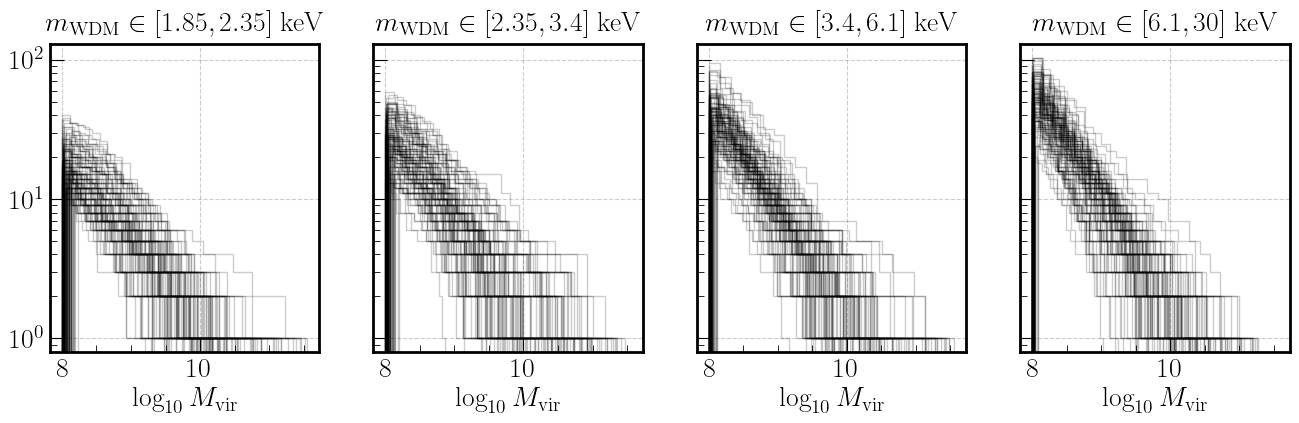

In [56]:
fig, axes = plt.subplots(
    1, num_wdm_bins, figsize=(4 * num_wdm_bins, 4), 
    sharex=True, sharey=True)

for i in range(num_wdm_bins):
    ax = axes.ravel()[i]
    select = (m_wdm > wdm_mass_bins[i]) & (m_wdm < wdm_mass_bins[i + 1])
    mvir_bin = mvir[select]
    for j in range(100):
        mvir_bin_j = mvir_bin[j]
        ax.hist(
            mvir_bin_j, bins=20, alpha=0.2, histtype='step', density=False,
            cumulative=-1, color='k')
    ax.set_xlabel(r'$\log_{10} M_{\rm vir}$')
    title = r"$m_\mathrm{{WDM}} \in [{}, {}]$ keV".format(
        wdm_mass_bins[i], wdm_mass_bins[i + 1])
    ax.set_title(title, fontsize=20)

axes[0].set_yscale('log')


plt.show()

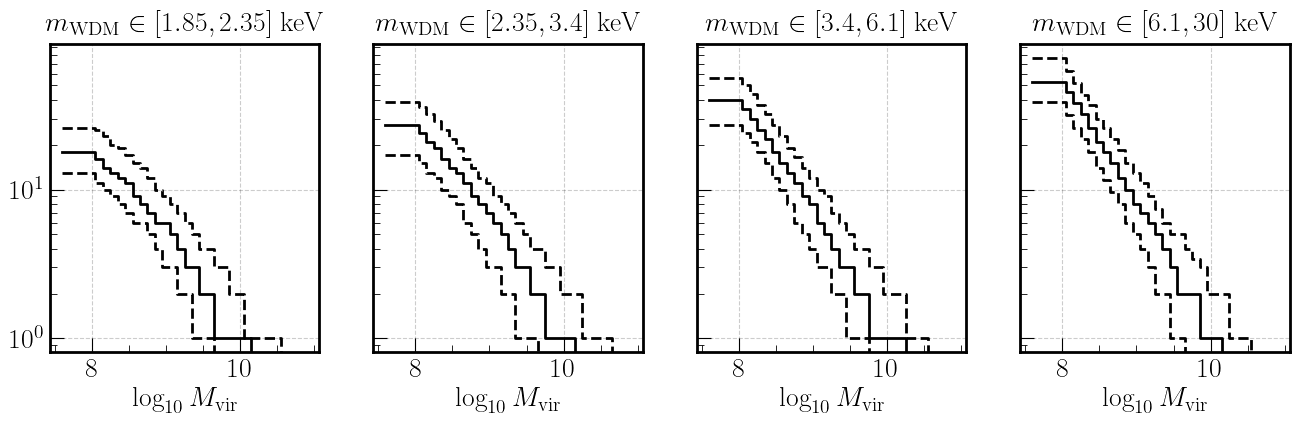

In [66]:
fig, axes = plt.subplots(
    1, num_wdm_bins, figsize=(4 * num_wdm_bins, 4), 
    sharex=True, sharey=True)

for i in range(num_wdm_bins):
    ax = axes.ravel()[i]
    select = (m_wdm > wdm_mass_bins[i]) & (m_wdm < wdm_mass_bins[i + 1])
    mvir_bin = mvir[select]

    bins = np.arange(7.5, 11., 0.1)
    counts_q = get_histogram_q(
        mvir_bin, bins, q=[50, 16, 84], cumulative=True)
    ax.step(bins[1:], counts_q[0], where='mid', color='k', lw=2)
    ax.step(bins[1:], counts_q[1], where='mid', ls='--', color='k', lw=2)
    ax.step(bins[1:], counts_q[2], where='mid', ls='--', color='k', lw=2)

    ax.set_xlabel(r'$\log_{10} M_{\rm vir}$')
    title = r"$m_\mathrm{{WDM}} \in [{}, {}]$ keV".format(
        wdm_mass_bins[i], wdm_mass_bins[i + 1])
    ax.set_title(title, fontsize=20)

axes[0].set_yscale('log')


plt.show()

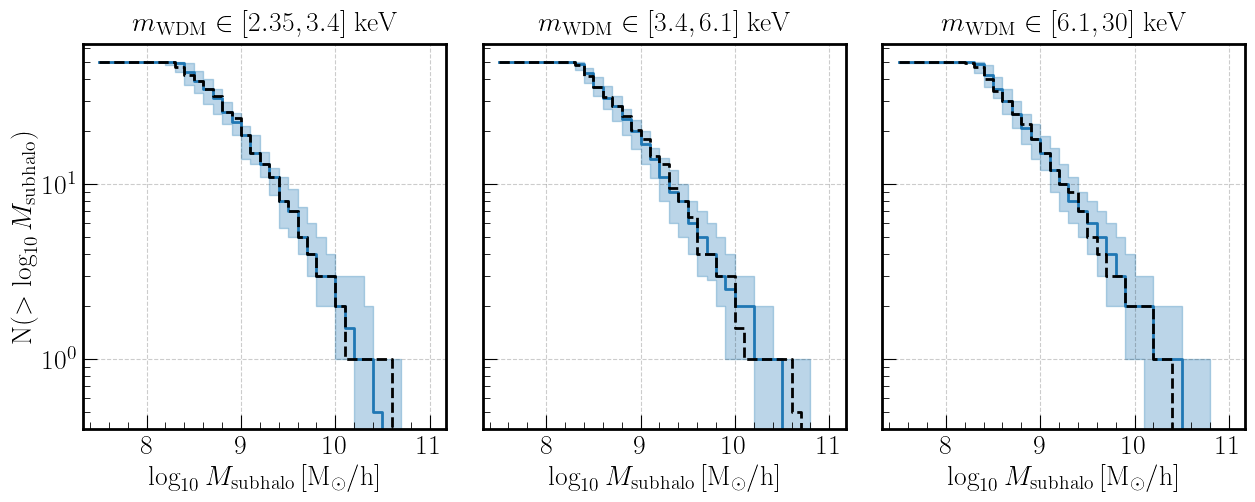

In [82]:
# define the bin for the subhalo mass function
# note that this is different from the bin for the wdm mass
bin_size = 0.1
plot_range = (7.5, 11)
q = [50, 16, 84]
cumulative = True
bins = np.arange(plot_range[0], plot_range[1] + bin_size, bin_size)
num_bins = len(bins) - 1
bins_plot = np.zeros(2 * num_bins)
bins_plot[::2] = bins[:-1] 
bins_plot[1::2] = bins[1:]

fig, axes = plt.subplots(
    1, num_wdm_bins, figsize=(5 * num_wdm_bins, 5), sharey=True, sharex=True)

for i in range(num_wdm_bins):
    ax = axes[i]

    # plot the generated samples
    counts_q = get_histogram_q(gen_samples_bins[i][..., -1], bins, q=q, cumulative=cumulative)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='C0', lw=2, 
        label='score-based diff')
    ax.fill_between(
        bins_plot, counts_q[1].repeat(2), counts_q[2].repeat(2),
        color='C0', alpha=0.3)

    # plot the truth samples
    counts_q = get_histogram_q(truth_samples_bins[i][..., -1], bins, q=q, cumulative=cumulative)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='k', lw=2, 
        ls='--', label='simulation')


axes[0].set_yscale('log')
axes[0].set_ylabel(r'N($> \log_{10} M_{\rm subhalo}$)')
for i, ax in enumerate(axes):
    ax.set_xlabel(r'$\log_{10} M_{\rm subhalo} \, [\rm M_\odot / h]$')

    title = r"$m_\mathrm{{WDM}} \in [{}, {}]$ keV".format(
        wdm_mass_bins[i], wdm_mass_bins[i + 1])
    ax.set_title(title, fontsize=20)

# create handles
handles, labels = ax.get_legend_handles_labels()
# fig.legend(
    # handles, labels, loc='upper center', ncol=2, fontsize=20)
fig.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

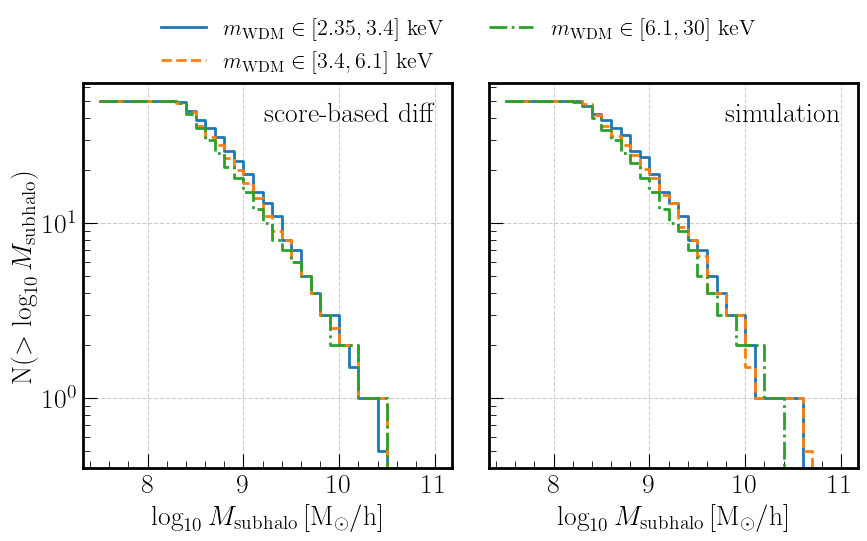

In [83]:
# define the bin for the subhalo mass function
# note that this is different from the bin for the wdm mass
bin_size = 0.1
plot_range = (7.5, 11)
q = [50, 16, 84]
cumulative = True
bins = np.arange(plot_range[0], plot_range[1] + bin_size, bin_size)
num_bins = len(bins) - 1
bins_plot = np.zeros(2 * num_bins)
bins_plot[::2] = bins[:-1] 
bins_plot[1::2] = bins[1:]

colors = ['C0', 'C1', 'C2', 'C3']
linestyles = ['-', '--', '-.', ':']

fig, axes = plt.subplots(
    1, 2, figsize=(10, 5), sharey=True, sharex=True)

# plot the generated samples
for i in range(num_wdm_bins):

    label = r"$m_\mathrm{{WDM}} \in [{}, {}]$ keV".format(
        wdm_mass_bins[i], wdm_mass_bins[i + 1])
    counts_q = get_histogram_q(gen_samples_bins[i][..., -1], bins, q=q, cumulative=cumulative)
    axes[0].plot(
        bins_plot, counts_q[0].repeat(2), color=colors[i], lw=2,
        ls=linestyles[i], label=label)

    counts_q = get_histogram_q(truth_samples_bins[i][..., -1], bins, q=q, cumulative=cumulative)
    axes[1].plot(
        bins_plot, counts_q[0].repeat(2), color=colors[i], lw=2,
        ls=linestyles[i], label=label)


axes[0].set_yscale('log')
axes[0].set_ylabel(r'N($> \log_{10} M_{\rm subhalo}$)')
axes[0].set_xlabel(r'$\log_{10} M_{\rm subhalo} \, [\rm M_\odot / h]$')
axes[1].set_xlabel(r'$\log_{10} M_{\rm subhalo} \, [\rm M_\odot / h]$')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, fontsize=16, loc='upper center', ncol=2,
    bbox_to_anchor=(0.5, 1.05))
axes[0].text(
    0.95, 0.95, 'score-based diff', transform=axes[0].transAxes,
    fontsize=20, va='top', ha='right')
axes[1].text(
    0.95, 0.95, 'simulation', transform=axes[1].transAxes,
    fontsize=20, va='top', ha='right')

fig.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

### Radius

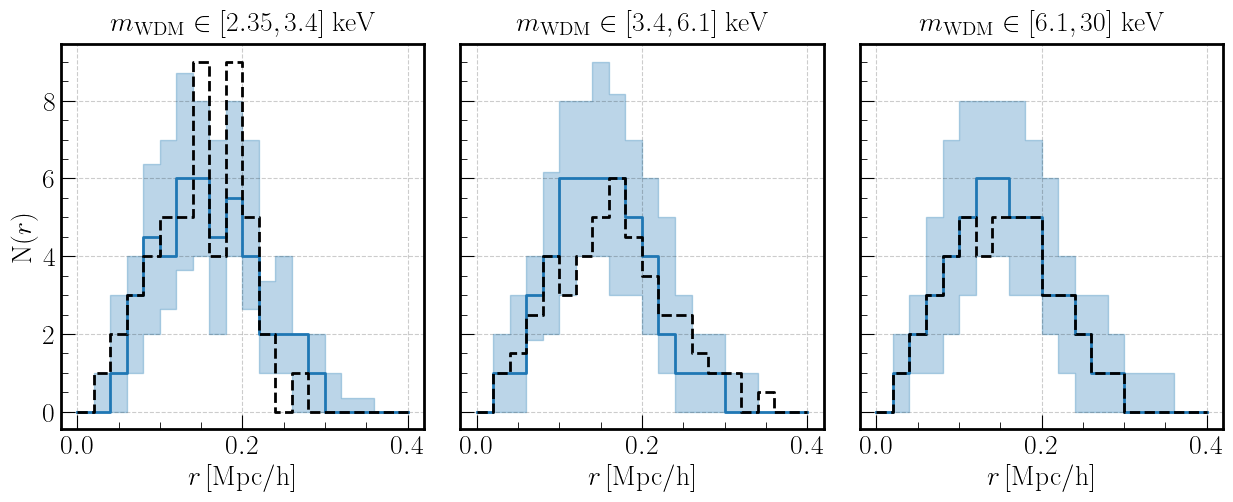

In [84]:
# define the bin for the subhalo mass function
# note that this is different from the bin for the wdm mass
bin_size = 0.02
plot_range = (0., 0.4)
q = [50, 16, 84]
cumulative = False
bins = np.arange(plot_range[0], plot_range[1] + bin_size, bin_size)
num_bins = len(bins) - 1
bins_plot = np.zeros(2 * num_bins)
bins_plot[::2] = bins[:-1] 
bins_plot[1::2] = bins[1:]

fig, axes = plt.subplots(
    1, num_wdm_bins, figsize=(5 * num_wdm_bins, 5), sharey=True, sharex=True)

for i in range(num_wdm_bins):
    ax = axes[i]

    # plot the generated samples
    pos = gen_samples_bins[i][..., :3]
    rad = np.linalg.norm(pos, axis=-1)
    counts_q = get_histogram_q(rad, bins, q=q, cumulative=cumulative)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='C0', lw=2, 
        label='score-based diff')
    ax.fill_between(
        bins_plot, counts_q[1].repeat(2), counts_q[2].repeat(2),
        color='C0', alpha=0.3)

    # plot the truth samples
    pos = truth_samples_bins[i][..., :3]
    rad = np.linalg.norm(pos, axis=-1)
    counts_q = get_histogram_q(rad, bins, q=q, cumulative=cumulative)   
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='k', lw=2, 
        ls='--', label='simulation')

# axes[0].set_yscale('log')
axes[0].set_ylabel(r'N($r$)')
for i, ax in enumerate(axes):
    ax.set_xlabel(r'$r \, [\rm Mpc / h]$')

    title = r"$m_\mathrm{{WDM}} \in [{}, {}]$ keV".format(
        wdm_mass_bins[i], wdm_mass_bins[i + 1])
    ax.set_title(title, fontsize=20)

# create handles
handles, labels = ax.get_legend_handles_labels()
# fig.legend(
    # handles, labels, loc='upper center', ncol=2, fontsize=20)
fig.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

### Density profiles

In [85]:
# calculate the density profiles for each WDM bins
r_min = 0.01
r_max = 0.5
num_bins = 5  # this is the number of bins for the density profile not the WDM mass
log_r_bins = np.linspace(np.log10(r_min), np.log10(r_max), num_bins + 1)

gen_log_rho = []
for i in range(num_wdm_bins):
    temp = []
    for samples in gen_samples_bins[i]:
        pos = samples[..., :3]
        rad = np.linalg.norm(pos, axis=-1)
        log_mvir = samples[..., -1]

        rho = jgnn_ut.particles.calc_rho(
            rad, 10**log_mvir, r_min, r_max, num_bins=num_bins)[0]
        temp.append(np.log10(rho))
    gen_log_rho.append(temp)

truth_log_rho = []
for i in range(num_wdm_bins):
    temp = []
    for samples in truth_samples_bins[i]:
        pos = samples[..., :3]
        rad = np.linalg.norm(pos, axis=-1)
        log_mvir = samples[..., -1]

        rho = jgnn_ut.particles.calc_rho(
            rad, 10**log_mvir, r_min, r_max, num_bins=num_bins)[0]
        temp.append(np.log10(rho))
    truth_log_rho.append(np.array(temp))

/tmp/ipykernel_4007302/1400352345.py:17: RuntimeWarning: divide by zero encountered in log10
  temp.append(np.log10(rho))
/tmp/ipykernel_4007302/1400352345.py:30: RuntimeWarning: divide by zero encountered in log10
  temp.append(np.log10(rho))


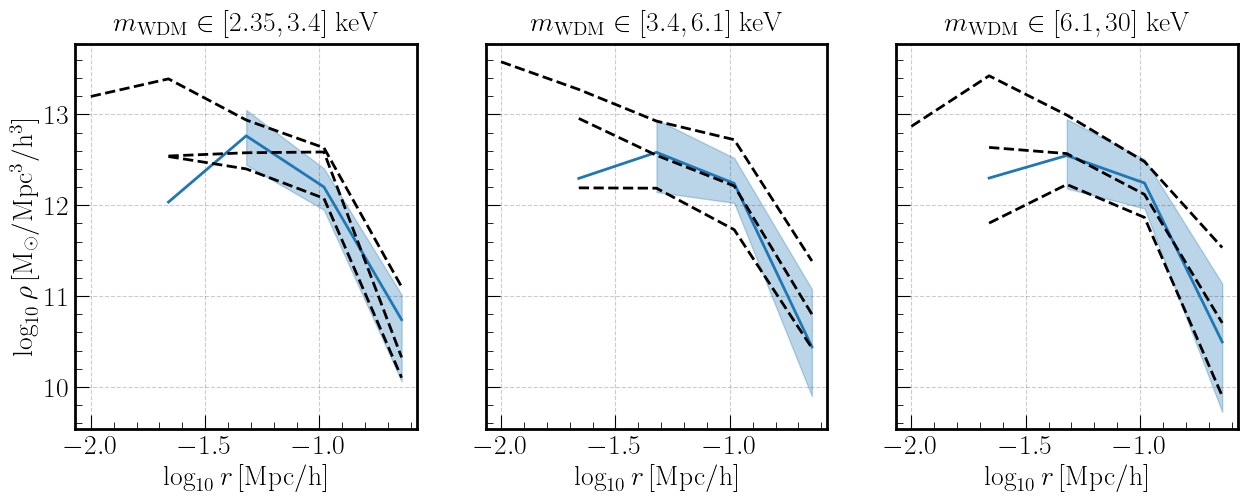

In [86]:
fig, axes = plt.subplots(
    1, num_wdm_bins, figsize=(5 * num_wdm_bins, 5), 
    sharey=True, sharex=True)

for i in range(num_wdm_bins):
    ax = axes[i]
    
    gen_log_rho_q = np.nanpercentile(gen_log_rho[i], q=q, axis=0)
    ax.plot(
        log_r_bins[:-1], gen_log_rho_q[0], color='C0', lw=2,
        label='score-based diff')
    ax.fill_between(
        log_r_bins[:-1], gen_log_rho_q[1], gen_log_rho_q[2],
        color='C0', alpha=0.3)
    
    truth_log_rho_q = np.nanpercentile(truth_log_rho[i], q=q, axis=0)
    ax.plot(
        log_r_bins[:-1], truth_log_rho_q[0], color='k', lw=2,
        ls='--', label='simulation')
    ax.plot(
        log_r_bins[:-1], truth_log_rho_q[1], color='k', lw=2,
        ls='--')
    ax.plot(
        log_r_bins[:-1], truth_log_rho_q[2], color='k', lw=2,
        ls='--')

    ax.set_xlabel(r'$\log_{10} r \, [\rm Mpc / h]$')
    title = r"$m_\mathrm{{WDM}} \in [{}, {}]$ keV".format(
        wdm_mass_bins[i], wdm_mass_bins[i + 1])
    ax.set_title(title, fontsize=20)

axes[0].set_ylabel(r'$\log_{10} \rho \, [\rm M_\odot / \rm Mpc^3 / h^3]$')
plt.show()

### Pair-wise distances

In [87]:
def calc_pair_dist(pos1, pos2):
    diff = (pos1[:, None, :] - pos2[None, :, :])
    dist = np.sqrt((diff**2).sum(axis=-1))
    dist = dist[dist > 0]  # only works if there are no particles at the same position
    return dist

def calc_tpcf(pos, num_random_factor=10, box_size=1):
    # randomly generate the catalogs7
    num_random = int(num_random_factor * len(pos))
    pos_random = np.random.uniform(
        low=-box_size, high=box_size, size=(num_random, pos.shape[-1]))
    DR_dist = calc_pair_dist(pos, pos_random)
    RR_dist = calc_pair_dist(pos_random, pos_random)
    DD_dist = calc_pair_dist(pos, pos)

    # calculate the tpcf
    return DD_dist, RR_dist, DR_dist

In [88]:
truth_pair_dist = []
for i in range(num_wdm_bins):
    temp = []
    for sample in truth_samples_bins[i]:
        truth_pos = sample[:, :3]
        temp.append(calc_pair_dist(truth_pos, truth_pos))
    truth_pair_dist.append(np.stack(temp))

gen_pair_dist = []
for i in range(num_wdm_bins):
    temp = []
    for sample in gen_samples_bins[i]:
        gen_pos = sample[:, :3]
        temp.append(calc_pair_dist(gen_pos, gen_pos))
    gen_pair_dist.append(np.stack(temp))

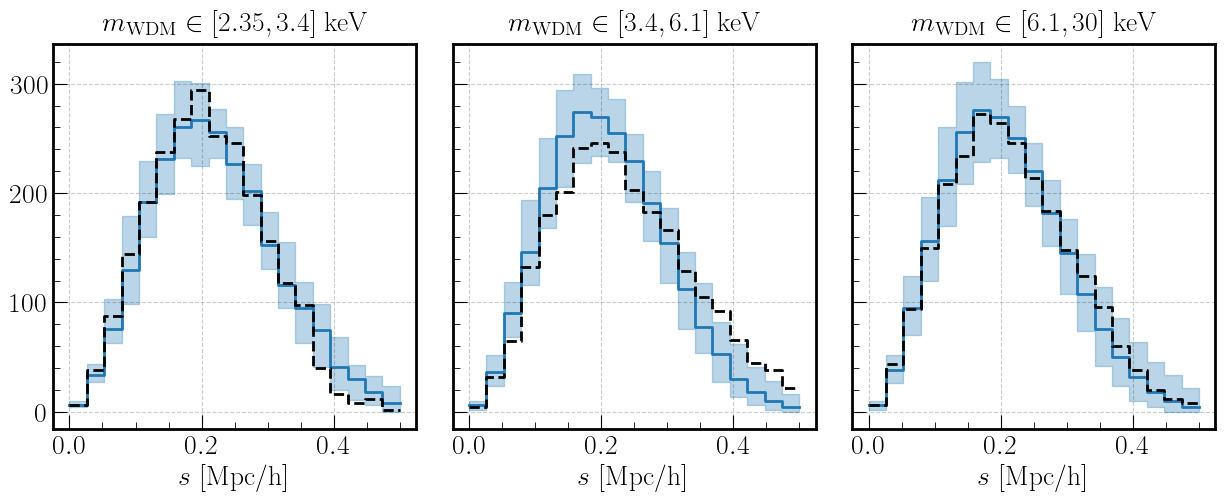

In [89]:
# pair-wise distance bins
bins = np.linspace(0, 0.5, 20)
num_bins = len(bins) - 1
bins_plot = np.zeros(2 * num_bins)
bins_plot[::2] = bins[:-1] 
bins_plot[1::2] = bins[1:]

fig, axes = plt.subplots(
    1, num_wdm_bins, figsize=(5 * num_wdm_bins, 5), sharex=True, sharey=True)

for i in range(num_wdm_bins):
    ax = axes[i]

    counts_q = get_histogram_q(
        gen_pair_dist[i], bins=bins, q=q, cumulative=False)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='C0', lw=2, 
        label='score-based diff')
    ax.fill_between(
        bins_plot, counts_q[1].repeat(2), counts_q[2].repeat(2),
        color='C0', alpha=0.3)

    counts_q = get_histogram_q(
        truth_pair_dist[i], bins=bins, q=q, cumulative=False)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='k', lw=2, ls='--',
        label='simulation')

# axes[0].set_yscale('log')
# axes[0].set_ylabel(r'N($> \log_{10} M_{\rm subhalo}$)')
for i, ax in enumerate(axes):
    ax.set_xlabel(r'$s$ [Mpc/h]')

    title = r"$m_\mathrm{{WDM}} \in [{}, {}]$ keV".format(
        wdm_mass_bins[i], wdm_mass_bins[i + 1])
    ax.set_title(title, fontsize=20)

# create handles
handles, labels = ax.get_legend_handles_labels()
# fig.legend(
    # handles, labels, loc='upper center', ncol=2, fontsize=20)
fig.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

### Pair-wise velocities

In [90]:
truth_pair_vel = []
for i in range(num_wdm_bins):
    temp = []
    for sample in truth_samples_bins[i]:
        truth_vel = sample[:, 3:6]
        temp.append(calc_pair_dist(truth_vel, truth_vel))
    truth_pair_vel.append(np.stack(temp))

gen_pair_vel = []
for i in range(num_wdm_bins):
    temp = []
    for sample in gen_samples_bins[i]:
        gen_vel = sample[:, 3:6]
        temp.append(calc_pair_dist(gen_vel, gen_vel))
    gen_pair_vel.append(np.stack(temp))

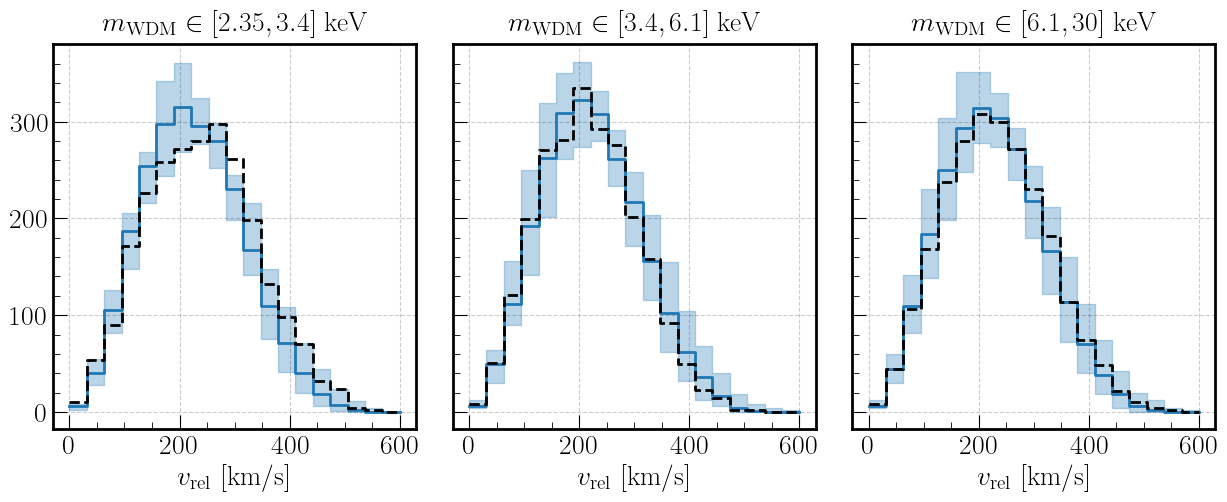

In [91]:
# pair-wise distance bins
bins = np.linspace(0, 600, 20)
num_bins = len(bins) - 1
bins_plot = np.zeros(2 * num_bins)
bins_plot[::2] = bins[:-1] 
bins_plot[1::2] = bins[1:]

fig, axes = plt.subplots(
    1, num_wdm_bins, figsize=(5 * num_wdm_bins, 5), sharex=True, sharey=True)

for i in range(num_wdm_bins):
    ax = axes[i]

    counts_q = get_histogram_q(
        gen_pair_vel[i], bins=bins, q=q, cumulative=False)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='C0', lw=2, 
        label='score-based diff')
    ax.fill_between(
        bins_plot, counts_q[1].repeat(2), counts_q[2].repeat(2),
        color='C0', alpha=0.3)

    counts_q = get_histogram_q(
        truth_pair_vel[i], bins=bins, q=q, cumulative=False)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='k', lw=2, ls='--',
        label='simulation')

# axes[0].set_yscale('log')
# axes[0].set_ylabel(r'N($> \log_{10} M_{\rm subhalo}$)')
for i, ax in enumerate(axes):
    ax.set_xlabel(r'$v_\mathrm{rel}$ [km/s]')

    title = r"$m_\mathrm{{WDM}} \in [{}, {}]$ keV".format(
        wdm_mass_bins[i], wdm_mass_bins[i + 1])
    ax.set_title(title, fontsize=20)

# create handles
handles, labels = ax.get_legend_handles_labels()
fig.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()